In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
import sqlite3
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
%matplotlib inline
from fbprophet import Prophet
pd.set_option('display.max_rows', 500)

In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed 

In [2]:
conn = sqlite3.connect('bosh.db')
c = conn.cursor()

In [3]:
###PARAMS
item_id = 362
store_id = 1

In [4]:
sales = pd.read_sql(f'select * from sales where item_id = {item_id} and store_id = {store_id}', con = conn)[1000:]

In [5]:
dates = pd.read_sql('select * from dates', con = conn).set_index('date_id')

In [6]:
holidays = pd.read_sql('select * from holidays', con = conn)

In [7]:
sales_df = sales.merge(dates['date_name'], left_on = 'date_id', right_index = True).reset_index()
sales_df['date_name'] = sales_df['date_name'].map(lambda x: pd.to_datetime(x))
sales_df['ds'] = sales_df['date_name']
sales_df['y'] = sales_df['sales_count']
sales_df['log1plusy'] = sales_df['y'].apply(lambda x: np.log(1+x))

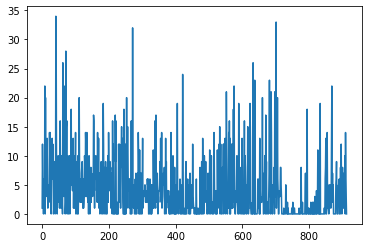

In [8]:
sales_df['sales_count'].plot()

In [9]:
quantiles_list = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

def wpl(y_true, y_pred, tau):
    err = y_true - y_pred
    return np.mean(np.max((tau * err, (tau-1) * err), axis = 0))

class Series:
    def __init__(self, df, valcol):
        self.df = df
        self.columns = list(df.columns)
        self.valcol = valcol
        self.tseries = df[valcol]
        self.tseries_normed = (df[valcol] - df[valcol].mean())/df[valcol].std()
        self.tseries_log = np.log(2+df[valcol])
        self.length = len(df[valcol])
        self.description = df[valcol].describe()
        
    def plot_series(self, idx_range, **subplkwargs):
        plot_range = idx_range
        fig, ax = plt.subplots(**subplkwargs)
        ax.plot(tseries[plot_range])
        
    def plot_forecast(self, history, forecast, forecaste_conf_ints, back = 28, forward = 28, **subplkwargs):
        maxidx = history.index[-1]
        forecast.index = pd.RangeIndex(maxidx + 1, maxidx + 1 + forward)
        plot_df = pd.DataFrame(history[-back:].append(forecast)).rename({0:'Sales'}, axis = 1)
        plot_df.loc[forecast.index, 'Type'] = 'Forecast'
        plot_df['Type'].fillna('Historic', inplace = True)
        plot_df['forecast_conf_int_lower'], plot_df['forecast_conf_int_upper'] = plot_df['Sales'], plot_df['Sales']
        plot_df.loc[forecast.index, 'forecast_conf_int_lower'] = forecast_conf_int['conf_int_lower'].values
        plot_df.loc[forecast.index, 'forecast_conf_int_upper'] = forecast_conf_int['conf_int_upper'].values
        fig, ax = plt.subplots(**subplkwargs)
        ax.plot(plot_df[plot_df['Type'] == 'Historic']['Sales'], color = 'black')
        ax.plot(plot_df[plot_df['Type'] == 'Forecast']['Sales'], color = 'green')
        ax.fill_between(plot_df.index, plot_df['forecast_conf_int_lower'], plot_df['forecast_conf_int_upper'], alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
        
    def plot_acf(self, lags = [0,365], **subplkwargs):
        fig, ax = plt.subplots(**subplkwargs)
        autocorrelation_plot(sales[self.valcol], ax = ax)
        ax.set_xlim(lags)
        
    def model_arima(self, data, p=7, d=1, q=0):
        model = ARIMA(data, order=(p,d,q))
        model_fit = model.fit(disp=0)
        return(model, model_fit)
    
    def model_forecast(self, model_fit, forward = 28):
        forecast, forecast_stderr, forecast_conf_int = model_fit.forecast(forward)
        forecast = pd.Series(forecast)
        forecast_stderr = pd.Series(forecast_stderr)
        forecast_conf_int = pd.DataFrame(forecast_conf_int).rename({0:'conf_int_lower', 1:'conf_int_upper'}, axis = 1)
        maxidx = self.tseries.index[-1]
        forecast.index = pd.RangeIndex(maxidx + 1, maxidx + 1 + forward)
        self.forecast = forecast
        self.forecast_stderr = forecast_stderr
        self.forecast_conf_int = forecast_conf_int
        return(forecast, forecast_stderr, forecast_conf_int)
    
    def fit_Prophet(self, ds, y, **params):
        country_hols = params.pop('add_country_holidays')
        model = Prophet(**params)
        self.df['y'] = self.df[y]
        self.df['ds'] = self.df[ds]
        if country_hols:
            model.add_country_holidays(country_name=country_hols)
        model.fit(self.df)
        return(model)
    
    def forecast_Prophet(self, model, periods):
        future = model.make_future_dataframe(periods=periods)
        forecast = model.predict(future)
        return(forecast)
    
    def predsamples_Prophet(self, model, forecast):
        ps = model.predictive_samples(forecast)
        return(ps)

    def predsamples_quantiles(self, samples, quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]):
        #expects samples of form given by predsamples_Prophet method
        yhat_samples = samples['yhat']
        yhat_samples_df = pd.DataFrame(yhat_samples, index = np.arange(yhat_samples.shape[0]))
        yhat_samples_qs = yhat_samples_df.quantile(quantiles, axis = 1).T
        return(yhat_samples_qs)
    
    ###PROPHET FUNC

In [10]:
s = Series(sales_df, 'sales_count')

In [11]:
prophparams = {'weekly_seasonality':True, 'add_country_holidays': 'US'}
model = s.fit_Prophet(ds = 'ds', y = 'log1plusy', **prophparams)
future = model.make_future_dataframe(periods=56)
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


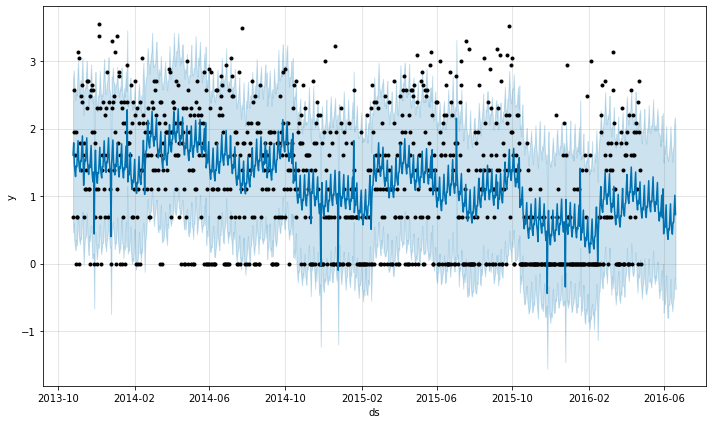

In [12]:
fig1 = model.plot(forecast)

In [13]:
pred_samples = s.predsamples_Prophet(model, forecast)
quantiles = s.predsamples_quantiles(pred_samples)

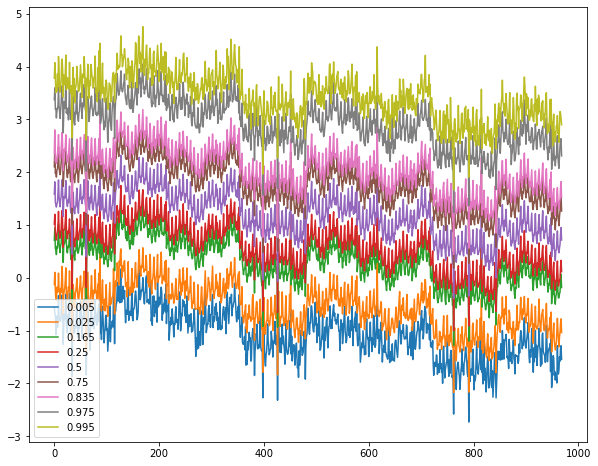

In [14]:
quantiles.plot(**{'figsize':(10,8)})

In [15]:
y = s.tseries
qtidy = quantiles.reset_index().melt(id_vars = ['index'],
                                    value_vars = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995],
                                    var_name='quantile', value_name = 'prediction')\
                             .merge(y, left_on = 'index', right_index = True)
qtidy['prediction'] = qtidy['prediction'].map(lambda x: 0 if x < 0 else x)

In [16]:
qtidy['expred'] = np.exp(qtidy['prediction']) - 1

In [17]:
prediction_col = 'expred'
qtidy['wpl'] = qtidy.apply(lambda x: wpl(x['sales_count'], x[prediction_col], x['quantile']), axis = 1)
qtidy.head(20)

,index,quantile,prediction,sales_count,expred,wpl
0,0,0.005,0.000000,1,0.000000,0.005000
969,0,0.025,0.000000,1,0.000000,0.025000
1938,0,0.165,0.711787,1,1.037629,0.031420
2907,0,0.25,1.017108,1,1.765186,0.573889
3876,0,0.5,1.586180,1,3.885050,1.442525
4845,0,0.75,2.106186,1,7.216840,1.554210
5814,0,0.835,2.371699,1,9.715578,1.438070
6783,0,0.975,3.377358,1,28.293277,0.682332
7752,0,0.995,3.782050,1,42.905940,0.209530
1,1,0.005,0.000000,12,0.000000,0.060000


In [18]:
qtidy['wpl'].describe()

count    8217.000000
mean        0.835782
std         1.614466
min         0.000000
25%         0.095000
50%         0.334217
75%         0.914562
max        21.628700
Name: wpl, dtype: float64

In [19]:
qtidy['wpl'].sum()

6867.6224048199465

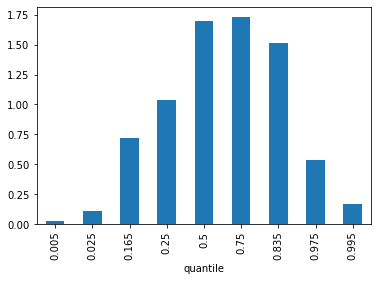

In [20]:
qtidy.groupby('quantile')['wpl'].mean().plot.bar()

In [22]:
qtidy[(qtidy['quantile'] == 0.995) & (qtidy['wpl'] > 1)].sort_values(by = 'sales_count')

,index,quantile,prediction,sales_count,expred,wpl
8546,794,0.995,2.676291,18,13.531096,4.446560
8585,833,0.995,2.586163,19,12.278721,6.687672
8384,632,0.995,3.136162,26,22.015360,3.964717


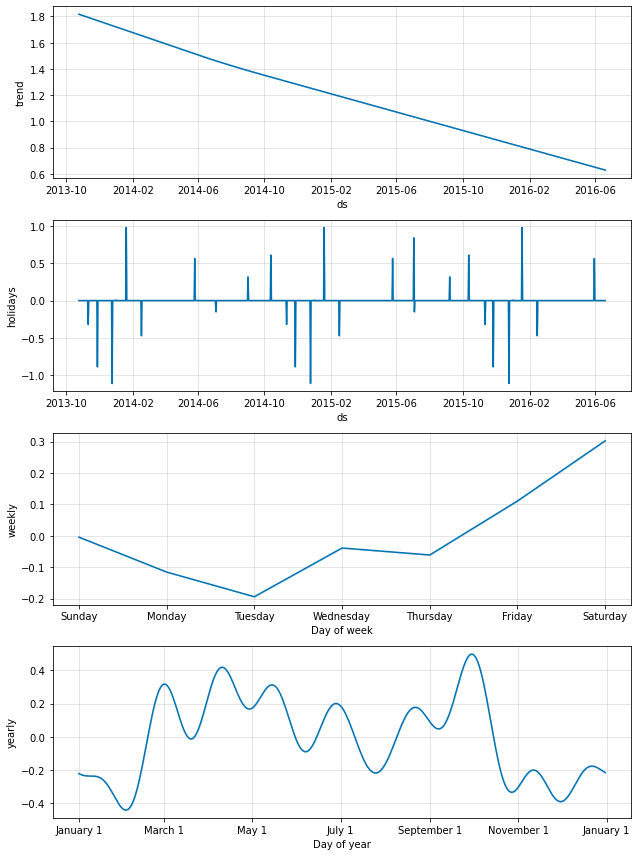

In [24]:
fig = model.plot_components(forecast)